# WORKFLOW

- 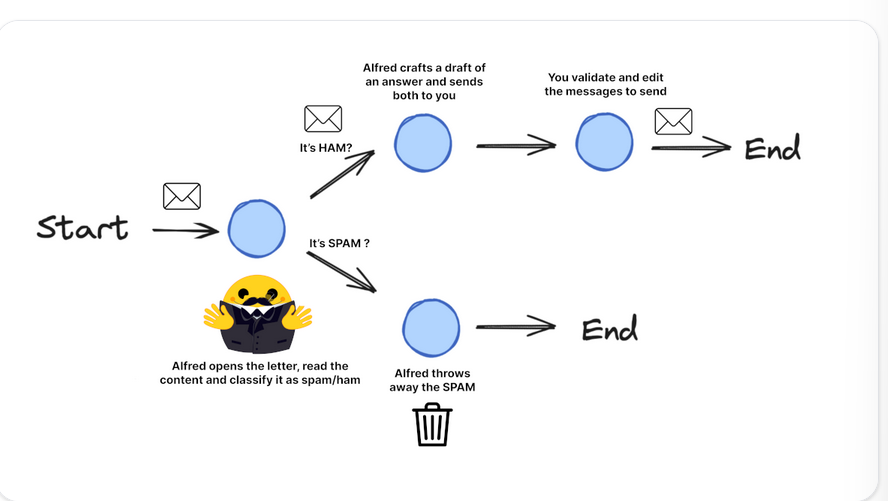


In [7]:
import os
from typing import TypedDict, List,Dict,Any,Optional
from langgraph.graph import StateGraph,START,END
from langchain_openai import ChatOpenAI
from langchain_core.messages import HumanMessage

In [8]:
'''DEFINE STATE'''
class EmailState(TypedDict):
    email:Dict[str,Any]
    email_category:Optional[str]
    spam_reason:Optional[str]
    is_spam:Optional[bool]
    email_draft:Optional[str]
    messages:List[Dict[str,Any]]

In [9]:
'''DEFINE NODES'''
model=ChatOpenAI(temperature=0)
def read_email(state:EmailState):
    """Alfred reads and logs the incoming email"""
    email=state["email"]
    print(f"Alfred is processing an email from {email['sender']} with subject: {email['subject']} ")
    return {}
def classify_email(state: EmailState):
    """Alfred uses an LLM to determine if the email is spam or legitimate"""
    email=state["email"]
    prompt=f"""As Alfred the butler, analyze this email and determine if it is spam or legitimate.
    Email:
    From:{email['sender']}
    Subject:{email['subject']}
    Body:{email['body']}
    First, determmine if this email is spam. If it is spam, explain why.
    If it is legitimate, categorize it(inquiry,complaint,thank you,etc.).
    """
    messages=[HumanMessage(content=prompt)]
    response=model.invoke(messages)
    response_text=response.content.lower()
    is_spam="spam" in response_text and "not_spam" not in response_text
    spam_reason=None
    if is_spam and "reason:" in response_text:
        spam_reason=response_text.split("reason:")[1].strip()
    email_category=None
    if not is_spam:
        categories=["inquiry","complaint","thank you","request","information"]
        for category in categories:
            if category in response_text:
                email_category=category
                break
    new_messages=state.get("messages",[])+[
        {"role":"user","content":prompt},
        {"role":"assistant","content":response.content}
    ]
    return{
        "is_spam":is_spam,
        "spam_reason":spam_reason,
        "email_category":email_category,
        "messages":new_messages
    }
def handle_spam(state:EmailState):
    """Alfred discard spam email with a note"""
    print(f"Alfred has marked the email as spam. Reason: {state['spam_reason']}")
    print("The email has been moved to the spam folder.")
    return {}
def draft_response(state:EmailState):
    """Alfred drafts a preliminary response for legitimate emails"""
    email=state["email"]
    category=state["email_category"] or "general"
    prompt=f"""
    As Alfred the butler, draft a polite preliminary response to this email.
    Email:
    From: {email['sender']}
    Subject: {email['subject']}
    Body:{email['body']}
    This email has been categorized as:{category}
    Draft a brief, professional response that Mr. Hugg can review and personalize before sending.
    """
    messages=[HumanMessage(content=prompt)]
    response=model.invoke(messages)
    new_messages=state.get("messages",[])+[
        {"role":"user","content":prompt},
        {"role":"assistant","content":response.content}
    ]
    return{
        "email_draft": response.content,
        "messages":new_messages
    }
def notify_mr_hugg(state: EmailState):
    """Alfred notifies Mr. Hugg about the email and presents the draft response"""
    email=state["email"]
    print("\n"+"="*50)
    print(f"Sir, you've received an email from {email['sender']}.")
    print(f"Subject:{email['subject']}")
    print(f"Category:{state['email_category']}")
    print("\nI've prepared a draft response for your review:")
    print("-"*50)
    print(state["email_draft"])
    print("="*50+"\n")
    return {}

In [10]:
def route_email(state:EmailState)->str:
    """Determine the next step based on spam classification"""
    if state["is_spam"]:
        return "spam"
    else:
        return "legitimate"

In [11]:
email_graph=StateGraph(EmailState)
email_graph.add_node("read_email",read_email)
email_graph.add_node("classify_email",classify_email)
email_graph.add_node("handle_spam",handle_spam)
email_graph.add_node("draft_response",draft_response)
email_graph.add_node("notify_mr_hugg",notify_mr_hugg)
email_graph.add_edge(START,"read_email")
email_graph.add_edge("read_email","classify_email")
email_graph.add_conditional_edges(
    "classify_email",
    route_email,
    {
        "spam":"handle_spam",
        "legitimate":"draft_response"
    }
)
email_graph.add_edge("handle_spam",END)
email_graph.add_edge("draft_response",'notify_mr_hugg')
email_graph.add_edge("notify_mr_hugg",END)
compiled_graph=email_graph.compile()


In [12]:
legitimate_email={
    "sender":"john.smith@example.com",
    "subject":"Question about your services",
    "body": "Dear Mr. Hugg, I was referred to you by a colleague and I'm interested in learning more about your consulting services. Could we schedule a call next week? Best regards, John Smith "
}
spam_email={
    "sender":"winner@lottery-intl.com",
    "subject":"YOU HAVE WON $5,000,000!!!",
    "body":"CONGRATULATIONS! You have been selected as the winner of our international lottery! To claim your $5,000,000 prize, please send us your bank details and a processing fee of $100."
}
print("\nProcessing legitimate email...")
legitimate_result=compiled_graph.invoke({
    "email":legitimate_email,
    "is_spam":None,
    "spam_reason":None,
    "email_category":None,
    "email_draft":None,
    "messages":[]
})
print("\nProcessing spam email...")
spam_result=compiled_graph.invoke({
    "email":spam_email,
    "is_spam":None,
    "spam_reason":None,
    "email_category":None,
    "email_draft":None,
    "messages":[]
})


Processing legitimate email...
Alfred is processing an email from john.smith@example.com with subject: Question about your services 


RateLimitError: Error code: 429 - {'error': {'message': 'You exceeded your current quota, please check your plan and billing details. For more information on this error, read the docs: https://platform.openai.com/docs/guides/error-codes/api-errors.', 'type': 'insufficient_quota', 'param': None, 'code': 'insufficient_quota'}}

In [ ]:
import os
os.environ.get("LANGFUSE_PUBLIC_KEY")
os.environ.get("LANGFUSE_SECRET_KEY")
print('')


In [ ]:
from langfuse.callback import CallbackHandler
langfuse_handler=CallbackHandler()
legitimate_result=compiled_graph.invoke(
    input={"email":legitimate_email,"is_spam":None,"spam_reason":None,"email_category":None,"draft_response":None,"messages":[]},
    config={"callbacks":[langfuse_handler]}
)


ModuleNotFoundError: No module named 'langfuse.callback'

In [13]:
compiled_graph.get_graph().draw_mermaid_png()

b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\x01L\x00\x00\x02+\x08\x02\x00\x00\x00\x0b\x157w\x00\x00\x00\x01sRGB\x00\xae\xce\x1c\xe9\x00\x00 \x00IDATx\x9c\xec\xddgX\x13\xd9\xdb\x06\xf0\x93\x1eB\xef\x08"\x02\x8a\x884\x15\x85U\x14\x10\xb1c/\xa0\x04\xb0\xd7Uw\xc5\xb5\xed\xda\xcb\xba*\xea\xba\x7f\x15\x1b\n\x88\xd8\xb0c\xef]Q\x10\x01\x1b"HQ:\x81$\x84\xd4\xf7\xc3\xf8fY\xa5)\t\x13&\xcf\xef\x83W\x98\x99L\x9e\x98\xdc9\xe7L%\xc9d2\x04\x00 .2\xde\x05\x00\x00\x94\x0bB\x0e\x00\xc1A\xc8\x01 8\x089\x00\x04\x07!\x07\x80\xe0 \xe4\x00\x10\x1c\x15\xef\x02\xc0\x17\x9f\xb3\x04\xbc\n1\xafB"\x11\xcb\x84UR\xbc\xcbi\x18C\x83L\xa1\x914u\xa8\x9a:TS+\x06\xde\xe5\x80:\x91`?9\x8ed2\x94\xfe\xb8\xe2C*7+\x9doe\xcf\xa2\xd2I,\x1d\xaa\xbe1\xbd\xbaJ\x82wi\r\xa33)e\x85B~\x85\x98D&}H\xe3\xd98jZ;jv\xe8\xaa\x8dw]\xe0k\x10r\xdc<\xbb^\x96|\xbb\xdc\xc6Q\xd3\xba\x93f\xdbN\x9ax\x97\xd3$\x12\xb1\xecC*/\xeb\x15\xef}\n\xaf\xa7\xbf\xa1c\x0f]\xbc+\x02\xff\x82\x90\xe3 \xf7m\xd5\xc5C\x9f:\xfd\xa4\xdbc\x88!\xde\xb5(\x98P }p\xbe$\xff}U\xf